In [ ]:
import os
import pandas as pd
import sqlite3
import re


#sample_data = pd.read_csv(Sample_data,encoding='ISO-8859-1')
sample_data = pd.read_excel('Inventory List as at 2022.xlsx', sheet_name=0, header=1)
sample_data_cleaned = sample_data.loc[:, ~sample_data.columns.str.contains('^Unnamed')]

# Remove leading and trailing spaces from column names
sample_data_cleaned.columns = sample_data_cleaned.columns.str.strip()
sample_data_cleaned = sample_data_cleaned.dropna(subset=['Inventory ID'])

# Replace missing values
sample_data_cleaned = sample_data_cleaned.copy()  # Ensure we're working with a copy
sample_data_cleaned.fillna('', inplace=True)

# Replace empty spaces in 'Discontinued' and 'Reorder?' with 'no'
sample_data_cleaned['Discontinued?'] = sample_data_cleaned['Discontinued?'].replace('', 'No')
sample_data_cleaned['Reorder ?'] = sample_data_cleaned['Reorder ?'].astype(str)
sample_data_cleaned['Reorder ?'] = sample_data_cleaned['Reorder ?'].replace(['','-','0'], 'No')
sample_data_cleaned['Unit Price'] = sample_data_cleaned['Unit Price'].astype(str)


# Hardcoded exchange rates (as of a specific date)
exchange_rates = {
    'USD': 0.75,  # Example rate: 1 USD = 0.75 GBP
    'EUR': 0.85,  # Example rate: 1 EUR = 0.85 GBP
}

def convert_to_gbp(price):
    currency_symbols = {
        '$': 'USD',
        '€': 'EUR',
        '£': 'GBP',
    }

    # Handle empty strings or non-string values
    if not isinstance(price, str) or price.strip() == '':
        return 0.0  # Or any other default value you prefer

    for symbol, code in currency_symbols.items():
        if symbol in price:
            # Extract numeric value, handling potential errors
            try:
                price_value = float(re.sub(r'[^\d.]', '', price))
            except ValueError:
                return 0.0  # Or handle the error differently

            if code != 'GBP':
                rate = exchange_rates[code]
                return price_value * rate
            else:
                return price_value

    # Default to GBP if no symbol is found, but handle potential errors
    try:
        return float(re.sub(r'[^\d.]', '', price))
    except ValueError:
        return 0.0  # Or handle the error as needed

# Convert the Unit Price column
sample_data_cleaned['Unit Price'] = sample_data_cleaned['Unit Price'].apply(convert_to_gbp)

# Correct data types where necessary
# Ensure the column is of string type before applying string operations
sample_data_cleaned['Qty'] = sample_data_cleaned['Qty'].astype(str)
sample_data_cleaned['Qty'] = pd.to_numeric(sample_data_cleaned['Qty'].str.replace(',', ''), errors='coerce').fillna(0).astype(int)

sample_data_cleaned['Unit Price'] = sample_data_cleaned['Unit Price'].astype(str)
sample_data_cleaned['Unit Price'] = pd.to_numeric(sample_data_cleaned['Unit Price'].str.replace(',', ''), errors='coerce').fillna(0).astype(float)

sample_data_cleaned['Inventory Value'] = sample_data_cleaned['Inventory Value'].astype(str)
sample_data_cleaned['Inventory Value'] = pd.to_numeric(sample_data_cleaned['Inventory Value'].str.replace(',', ''), errors='coerce').fillna(0).astype(float)

sample_data_cleaned['Reorder Level'] = sample_data_cleaned['Reorder Level'].astype(str)
sample_data_cleaned['Reorder Level'] = pd.to_numeric(sample_data_cleaned['Reorder Level'].str.replace(',', ''), errors='coerce').fillna(1).astype(float)

# Pareto Chart for Inventory Value by Supplier
supplier_value = sample_data_cleaned.groupby('Supplier Name')['Inventory Value'].sum().sort_values(ascending=False)

unique_values = sample_data_cleaned['Reorder ?'].unique()
print("Unique values in 'Reorder ?':", unique_values)


Unique values in 'Reorder ?': ['Yes' 'No']


<ipython-input-1-936b57e90be9>:17: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  sample_data_cleaned.fillna('', inplace=True)


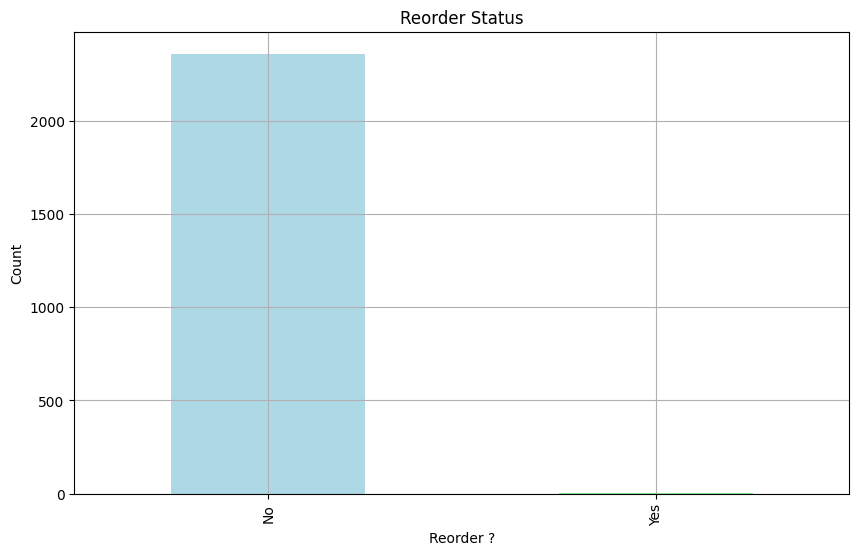

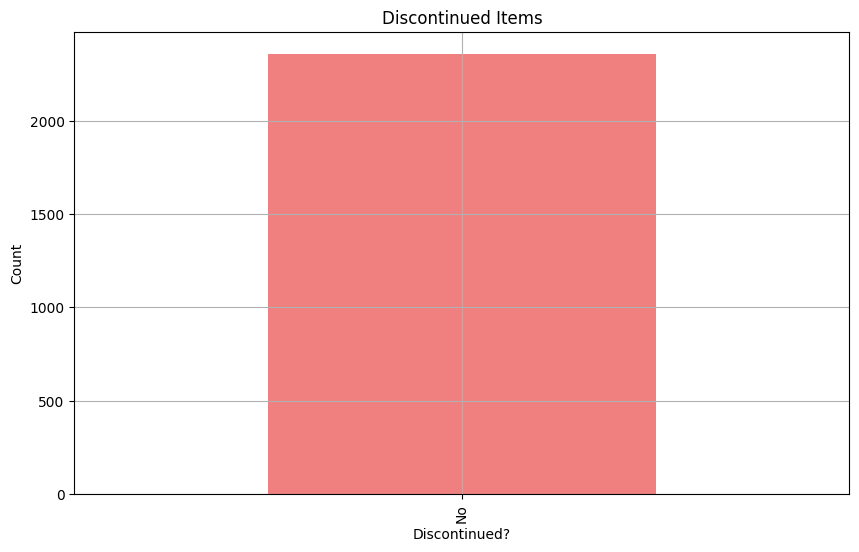

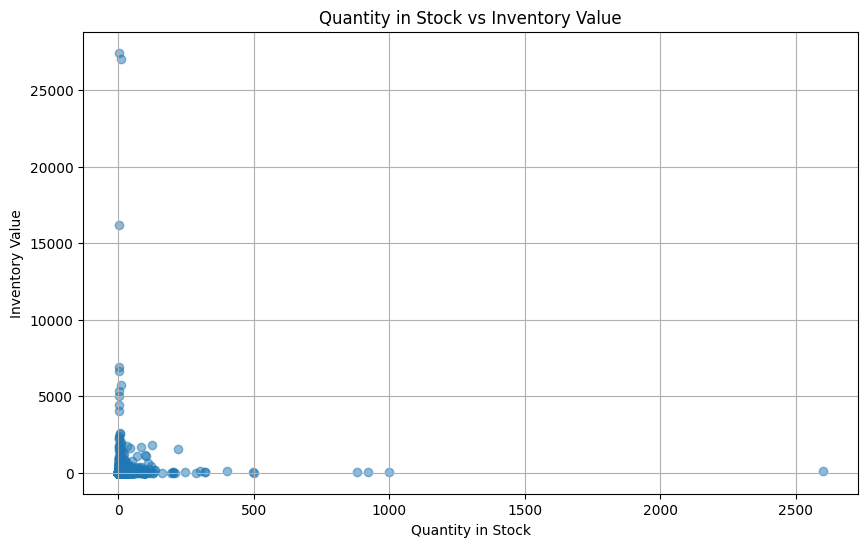

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Reorder Status
plt.figure(figsize=(10, 6))
sample_data_cleaned['Reorder ?'].value_counts().plot(kind='bar', color=['lightblue', 'lightgreen'])
plt.title('Reorder Status')
plt.xlabel('Reorder ?')
plt.ylabel('Count')
plt.grid(True)
plt.show()

# Discontinued Items
plt.figure(figsize=(10, 6))
sample_data_cleaned['Discontinued?'].value_counts().plot(kind='bar', color=['lightcoral', 'lightgrey'])
plt.title('Discontinued Items')
plt.xlabel('Discontinued?')
plt.ylabel('Count')
plt.grid(True)
plt.show()

# Scatter plot of Quantity in Stock vs Inventory Value
plt.figure(figsize=(10, 6))
plt.scatter(sample_data_cleaned['Qty'], sample_data_cleaned['Inventory Value'], alpha=0.5)
plt.title('Quantity in Stock vs Inventory Value')
plt.xlabel('Quantity in Stock')
plt.ylabel('Inventory Value')
plt.grid(True)
plt.show()

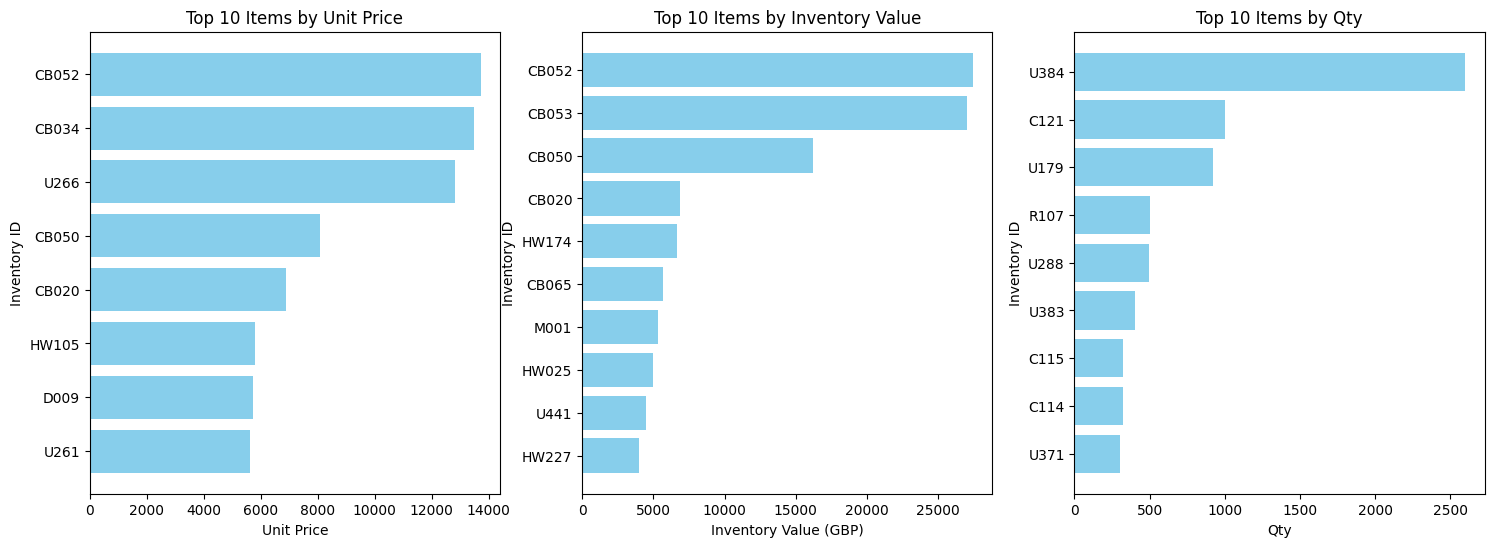

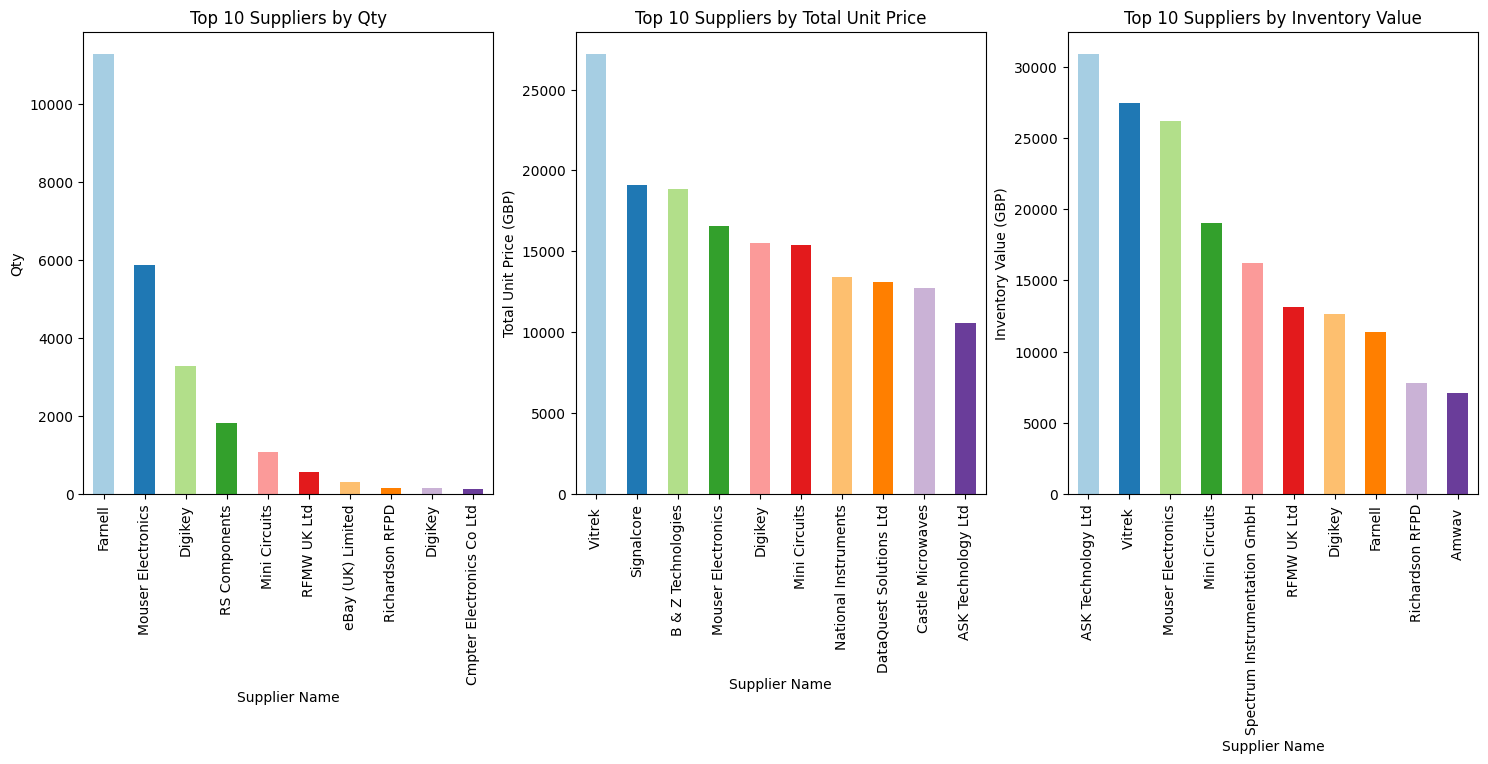

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

In [ ]:
def create_plots(sample_data_cleaned):
    # Sort the data by 'Unit Price' and select the top 10 items
    top_10_items = sample_data_cleaned.sort_values(by='Unit Price', ascending=False).head(10)
    # Sort the data by 'Inventory Value' and select the top 10 items
    top_10_items_1 = sample_data_cleaned.sort_values(by='Inventory Value', ascending=False).head(10)
    # Sort the data by 'Inventory Value' and select the top 10 items
    top_10_items_2 = sample_data_cleaned.sort_values(by='Qty', ascending=False).head(10)
    # Create subplots with 1 row and 3 columns
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))

    # Plotting the top 10 items by Unit Price
    axes[0].barh(top_10_items['Inventory ID'], top_10_items['Unit Price'], color='skyblue')
    axes[0].set_xlabel('Unit Price')
    axes[0].set_ylabel('Inventory ID')
    axes[0].set_title('Top 10 Items by Unit Price')
    axes[0].invert_yaxis()  # To display the highest value at the top

    # Plotting the top 10 items by Inventory Value
    axes[1].barh(top_10_items_1['Inventory ID'], top_10_items_1['Inventory Value'], color='skyblue')
    axes[1].set_xlabel('Inventory Value (GBP)')
    axes[1].set_ylabel('Inventory ID')
    axes[1].set_title('Top 10 Items by Inventory Value')
    axes[1].invert_yaxis()  # To display the highest value at the top

    # Plotting the top 10 items by Qty
    axes[2].barh(top_10_items_2['Inventory ID'], top_10_items_2['Qty'], color='skyblue')
    axes[2].set_xlabel('Qty')
    axes[2].set_ylabel('Inventory ID')
    axes[2].set_title('Top 10 Items by Qty')
    axes[2].invert_yaxis()  # To display the highest value at the top

    plt.show()  # Close the figure to free memory

    return plt

def plot_top_10_suppliers(sample_data_cleaned):
    # Create subplots with 1 row and 3 columns
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))
    # Define colors for the supplier plots
    colors = plt.cm.Paired.colors[:10]  # Use the first 10 colors from the Paired colormap

    # Plot 1: Top 10 Suppliers by Count
    top_suppliers = sample_data_cleaned.groupby('Supplier Name')['Qty'].sum().sort_values(ascending=False).head(10)
    top_suppliers.plot(kind='bar', color=colors, ax=axes[0])
    axes[0].set_title('Top 10 Suppliers by Qty')
    axes[0].set_xlabel('Supplier Name')
    axes[0].set_ylabel('Qty')
    axes[0].tick_params(axis='x', rotation=90)

    # Plot 2: Top 10 Suppliers by Total Unit Price
    top_suppliers_by_price = sample_data_cleaned.groupby('Supplier Name')['Unit Price'].sum().sort_values(ascending=False).head(10)
    top_suppliers_by_price.plot(kind='bar', color=colors, ax=axes[1])
    axes[1].set_title('Top 10 Suppliers by Total Unit Price')
    axes[1].set_xlabel('Supplier Name')
    axes[1].set_ylabel('Total Unit Price (GBP)')
    axes[1].tick_params(axis='x', rotation=90)

    # Plot 3: Top 10 Suppliers by Inventory Value
    supplier_value = sample_data_cleaned.groupby('Supplier Name')['Inventory Value'].sum().sort_values(ascending=False)
    top_10_supplier_value = supplier_value.nlargest(10)
    top_10_supplier_value.plot(kind='bar', color=plt.cm.Paired.colors[:10], ax=axes[2])
    axes[2].set_title('Top 10 Suppliers by Inventory Value')
    axes[2].set_xlabel('Supplier Name')
    axes[2].set_ylabel('Inventory Value (GBP)')
    axes[2].tick_params(axis='x', rotation=90)

    plt.show()  # Close the figure to free memory

    return plt

create_plots(sample_data_cleaned)
plot_top_10_suppliers(sample_data_cleaned)

In [ ]:
pip install pandas matplotlib seaborn squarify openpyxl

Unique values in 'Reorder ?': [1 0]
Class distribution before balancing:
Reorder ?
0    2359
1       2
Name: count, dtype: int64
Class distribution after alternative resampling:
Reorder ?
0    2359
1    2358
Name: count, dtype: int64
Logistic Regression Stratified Cross-Validation Scores: [0.74381625 0.74204947 0.72968198 0.69611307 0.71908127]
Logistic Regression Mean Stratified CV Score: 0.726148409893993
Results for Logistic Regression:
Accuracy: 0.735559088500265
F1 Score: 0.7890063424947146
MCC: 0.5574434590222365


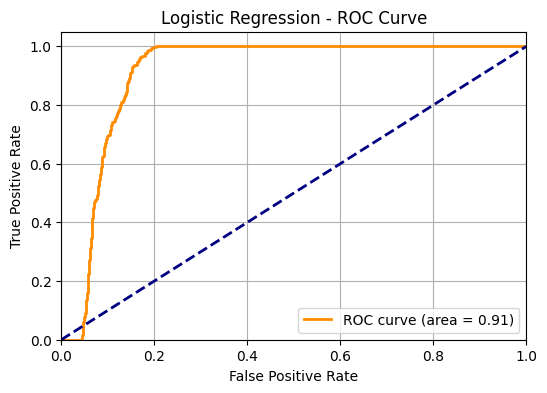

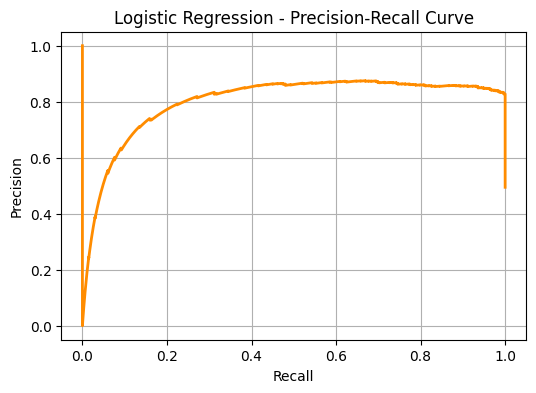

Logistic Regression - Classification Report:
              precision    recall  f1-score   support

  No Reorder       1.00      0.48      0.65       954
     Reorder       0.65      1.00      0.79       933

    accuracy                           0.74      1887
   macro avg       0.83      0.74      0.72      1887
weighted avg       0.83      0.74      0.72      1887



Decision Tree Stratified Cross-Validation Scores: [0.92579505 0.92402827 0.92402827 0.90459364 0.9204947 ]
Decision Tree Mean Stratified CV Score: 0.9197879858657245
Results for Decision Tree:
Accuracy: 0.9284578696343402
F1 Score: 0.9323985978968453
MCC: 0.8654778014502357


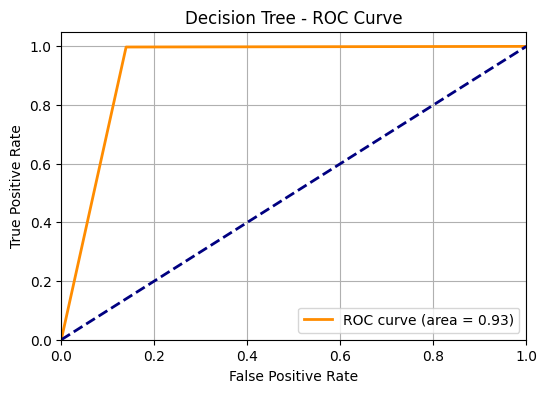

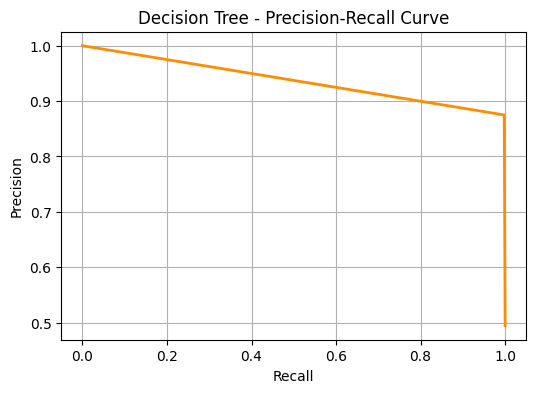

Decision Tree - Classification Report:
              precision    recall  f1-score   support

  No Reorder       1.00      0.86      0.92       954
     Reorder       0.88      1.00      0.93       933

    accuracy                           0.93      1887
   macro avg       0.94      0.93      0.93      1887
weighted avg       0.94      0.93      0.93      1887



Random Forest Stratified Cross-Validation Scores: [0.92579505 0.92402827 0.92579505 0.90636042 0.9204947 ]
Random Forest Mean Stratified CV Score: 0.9204946996466432
Results for Random Forest:
Accuracy: 0.9284578696343402
F1 Score: 0.9325337331334332
MCC: 0.8660101039283546


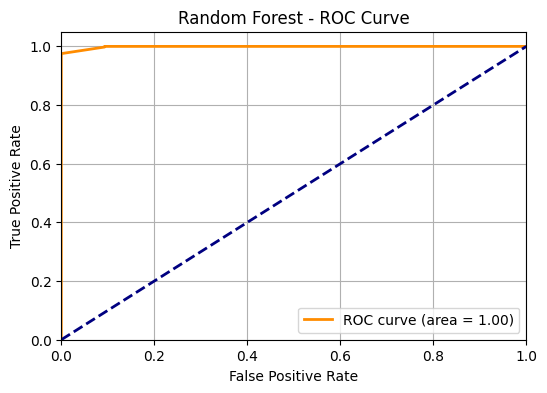

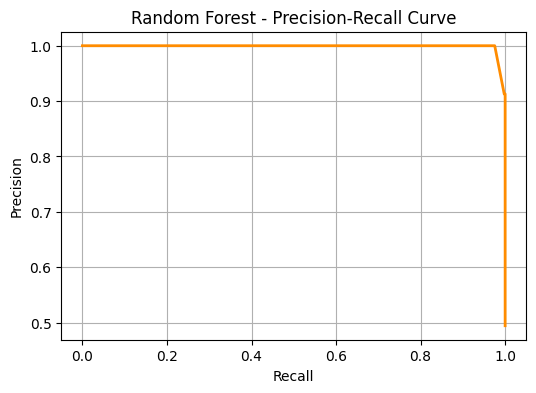

Random Forest - Classification Report:
              precision    recall  f1-score   support

  No Reorder       1.00      0.86      0.92       954
     Reorder       0.87      1.00      0.93       933

    accuracy                           0.93      1887
   macro avg       0.94      0.93      0.93      1887
weighted avg       0.94      0.93      0.93      1887





In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.combine import SMOTETomek
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve, f1_score, matthews_corrcoef

# Fill missing values
sample_data_cleaned['Qty'].fillna(sample_data_cleaned['Qty'].median(), inplace=True)
sample_data_cleaned['Reorder Level'].fillna(sample_data_cleaned['Reorder Level'].median(), inplace=True)
sample_data_cleaned['Unit Price'].fillna(sample_data_cleaned['Unit Price'].median(), inplace=True)
sample_data_cleaned['Inventory Value'].fillna(sample_data_cleaned['Inventory Value'].median(), inplace=True)

# Encode the target variable
label_encoder = LabelEncoder()
sample_data_cleaned['Reorder ?'] = label_encoder.fit_transform(sample_data_cleaned['Reorder ?'])

# Check the unique values in the target variable
unique_values = sample_data_cleaned['Reorder ?'].unique()
print("Unique values in 'Reorder ?':", unique_values)

# Ensure 'Reorder ?' is binary
assert set(sample_data_cleaned['Reorder ?'].unique()) == {0, 1}, "Target variable is not binary."

# Check class distribution
print("Class distribution before balancing:")
print(sample_data_cleaned['Reorder ?'].value_counts())

# Select features and target
features = ['Qty', 'Reorder Level','Unit Price', 'Inventory Value']
target = 'Reorder ?'
X = sample_data_cleaned[features]
y = sample_data_cleaned[target]

# # Use SMOTETomek with the custom SMOTE object
# smote_tomek = SMOTETomek(smote=smote, random_state=42)
# X_resampled, y_resampled = smote_tomek.fit_resample(X, y)

# # Define SMOTE with custom k_neighbors
# smote = SMOTE(random_state=42, k_neighbors=1)

# Using ADASYN
adasyn = ADASYN(random_state=42, n_neighbors=1)
X_resampled, y_resampled = adasyn.fit_resample(X, y)

# Check the new class distribution
print("Class distribution after alternative resampling:")
print(pd.Series(y_resampled).value_counts())

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_resampled)

# Split the scaled data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_resampled, test_size=0.4, random_state=42)

# Define models with some regularization to prevent overfitting
models = {
    "Logistic Regression": LogisticRegression(C=0.01),
    "Decision Tree": DecisionTreeClassifier(max_depth=1, min_samples_split=10, min_samples_leaf=5),
    "Random Forest": RandomForestClassifier(n_estimators=100, max_depth=1, min_samples_split=10, min_samples_leaf=5)
}

# Apply StratifiedKFold to maintain class balance in cross-validation
skf = StratifiedKFold(n_splits=5)


# Evaluate models and visualize performance
for model_name, model in models.items():
    # Stratified cross-validation
    cv_scores = cross_val_score(model, X_train, y_train, cv=skf)
    print(f"{model_name} Stratified Cross-Validation Scores: {cv_scores}")
    print(f"{model_name} Mean Stratified CV Score: {cv_scores.mean()}")

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    print(f"Results for {model_name}:")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("F1 Score:", f1_score(y_test, y_pred))
    print("MCC:", matthews_corrcoef(y_test, y_pred))


    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{model_name} - ROC Curve')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

    # Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(y_test, y_proba)
    plt.figure(figsize=(6, 4))
    plt.plot(recall, precision, lw=2, color='darkorange')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'{model_name} - Precision-Recall Curve')
    plt.grid(True)
    plt.show()

    # Print classification report
    print(f"{model_name} - Classification Report:")
    print(classification_report(y_test, y_pred, target_names=['No Reorder', 'Reorder']))
    print("\n")

# Optionally, save the models for future use
import joblib
for model_name, model in models.items():
    joblib.dump(model, f"{model_name.replace(' ', '_')}_model.pkl")